In [1]:
import numpy as np
import pandas as pd
import preprocess_data as prep
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from models import build_baseline, train_model_using_cross_val, sum_regions_predictions
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [2]:
STATE = 'MG'
TEST_YEAR = 2023
model_name = 'baseline'

In [3]:
state_to_code = {'RJ': 33, 'ES': 32, 'PR': 41, 'CE': 23, 'MA': 21,
                 'MG': 31, 'SC': 42, 'PE': 26, 'PB': 25, 'RN': 24,
                 'PI': 22, 'AL': 27, 'SE': 28, 'SP': 35, 'RS': 43,
                 'PA': 15, 'AP': 16, 'RR': 14, 'RO': 11, 'AM': 13,
                 'AC': 12, 'MT': 51, 'MS': 50, 'GO': 52, 'TO': 17,
                 'DF': 53, 'BA': 29}

In [4]:
df = prep.load_cases_data()
df = df.loc[df.uf == STATE]
df_clima_all = prep.load_climate_data()
df_clima = df_clima_all.loc[df_clima_all.geocode.astype(str).str[:2] == str(state_to_code[STATE])]

enso = prep.load_enso_data()

df_end = df.merge(df_clima, left_on = ['date', 'epiweek', 'geocode'], right_on = ['date', 'epiweek', 'geocode'])

df_end.date = pd.to_datetime(df_end.date)

df_end.set_index('date', inplace = True)

In [5]:
columns_to_normalize = ['casos', 'epiweek', 'temp_med', 'temp_amp', 'rel_humid_med', 'precip_tot', 'enso',
                            'R0', 'total_cases',
                             'peak_week', 'perc_geocode']

In [6]:
# generate the samples to train and test based on the regional data 
X_train, y_train = prep.generate_regional_train_samples(df_end, enso, TEST_YEAR, columns_to_normalize=columns_to_normalize, episcanner = True,
                                                       clima = True)

In [7]:
LOSS = 'msle'

In [8]:
batch_size = 4
model = build_baseline( hidden=64, features=12, predict_n=52, look_back=89, loss=LOSS, 
                  stateful = False, batch_size = batch_size,  optimizer = Adam(learning_rate=0.001), activation = 'relu')

model 

/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (4, 89, 12)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (4, 89, 64)            │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (4, 89, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (4, 64)                │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (4, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (4, 52)                │         3,380 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,116 (219.20 KB)

 Trainable params: 56,116 (219.20 KB)

 Non-trainable params: 0 (0.00 B)

None


<Functional name=functional, built=True>

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

In [10]:
epochs = 1000

In [11]:
TB_callback = TensorBoard(
            log_dir="./tensorboard",
            histogram_freq=0,
            write_graph=True,
            write_images=True,
            update_freq='epoch',
            # embeddings_freq=10
        )

hist = model.fit(
                X_train,
                y_train,
                batch_size=4,
                epochs=epochs,
                verbose=0,
                validation_data=(X_val, y_val),
                callbacks=[TB_callback]
                )


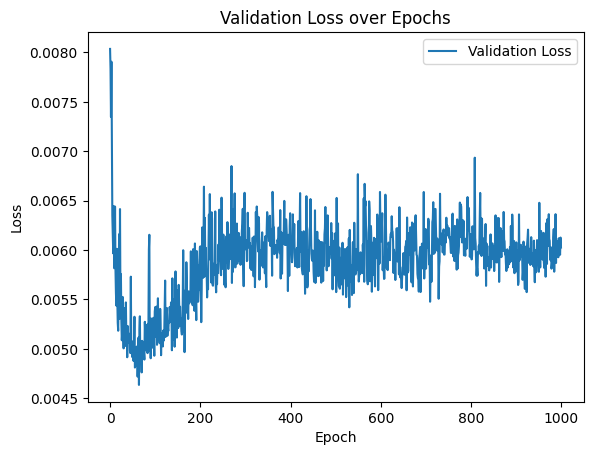

In [12]:
plt.figure()
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

In [13]:
%%time
model.save(f'./saved_models/model_groc_{STATE}_{TEST_YEAR-1}_{model_name}.keras')

df_preds_23 = sum_regions_predictions(model, df_end, enso, TEST_YEAR, columns_to_normalize, True, True)

df_preds_23['adm_1'] = STATE
df_preds_23['adm_0'] = 'BR'
df_preds_23['adm_2'] = pd.NA

df_preds_23.to_csv(f'./predictions/preds_groc_{STATE}_{TEST_YEAR}_{model_name}.csv', index = False)


CPU times: user 20min 55s, sys: 3.75 s, total: 20min 59s
Wall time: 21min 32s


In [14]:
df_23_base = pd.read_csv(f'./predictions/preds_{STATE}_{TEST_YEAR}_{model_name}.csv')
df_23_base.dates = pd.to_datetime(df_23_base.dates)
df_23_base.head()

,dates,lower,preds,upper,adm_1,adm_0,adm_2
0,2022-10-09,0.0,0.0,0.0,MG,BR,NaN
1,2022-10-16,0.0,0.0,0.0,MG,BR,NaN
2,2022-10-23,0.0,0.0,0.0,MG,BR,NaN
3,2022-10-30,0.0,0.0,0.0,MG,BR,NaN
4,2022-11-06,0.0,0.0,0.0,MG,BR,NaN


In [15]:
df_preds_23.head()

,dates,lower,preds,upper,adm_1,adm_0,adm_2
0,2022-10-09,0.0,0.0,0.0,MG,BR,<NA>
1,2022-10-16,0.0,0.0,0.0,MG,BR,<NA>
2,2022-10-23,0.0,0.0,0.0,MG,BR,<NA>
3,2022-10-30,0.0,0.0,0.0,MG,BR,<NA>
4,2022-11-06,0.0,0.0,0.0,MG,BR,<NA>


In [16]:
data_w = df[['casos']].resample('W-SUN').sum()

data_w.head()

,casos
date,
2010-01-03,2794
2010-01-10,3729
2010-01-17,4656
2010-01-24,6195
2010-01-31,7179


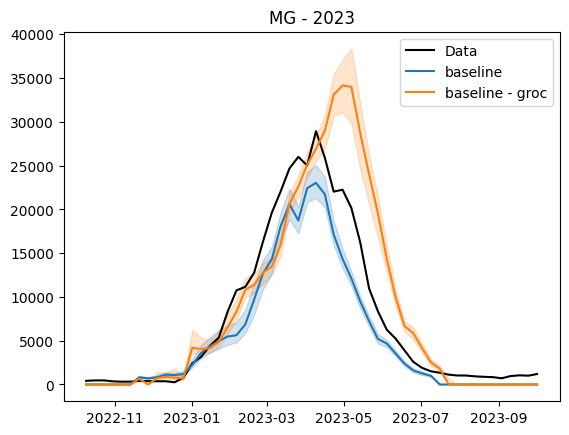

In [17]:
fig,ax = plt.subplots()

ax.plot(data_w.loc[data_w.index.isin(df_23_base.dates)].casos, label = 'Data', color = 'black')
ax.plot(df_23_base.dates, df_23_base.preds, label ='baseline')
ax.fill_between(df_23_base.dates, df_23_base.lower, df_23_base.upper,  color = 'tab:blue', alpha = 0.2)


ax.plot(df_preds_23.dates, df_preds_23.preds, label ='baseline - groc')

ax.fill_between(df_preds_23.dates, df_preds_23.lower, df_preds_23.upper, color = 'tab:orange', alpha = 0.2)

ax.legend()

ax.set_title(f'{STATE} - {TEST_YEAR}')

plt.show()

### Training the model for 2024:

In [18]:
from keras.models import load_model

model = load_model(f'./saved_models/model_groc_{STATE}_2022_{model_name}.keras')

In [19]:
TEST_YEAR = 2024

In [20]:
X_train, y_train = prep.generate_regional_train_samples(df_end, enso, TEST_YEAR, columns_to_normalize=columns_to_normalize,
                                                        episcanner = True, clima = True)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

In [21]:
hist = model.fit(
                X_train,
                y_train,
                batch_size=4,
                epochs=1000,
                verbose=0,
                validation_data=(X_val, y_val),
                callbacks=[TB_callback]
                )

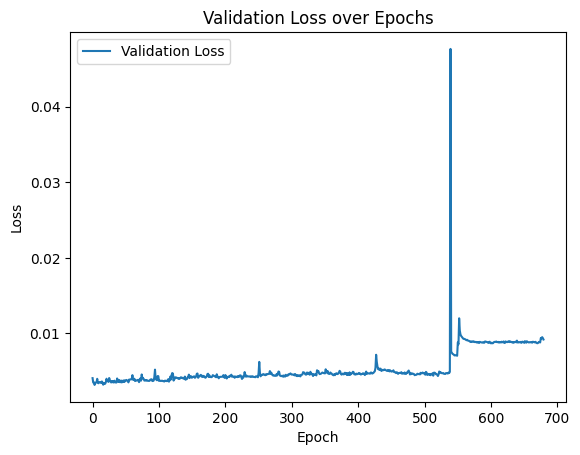

In [22]:
plt.figure()
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

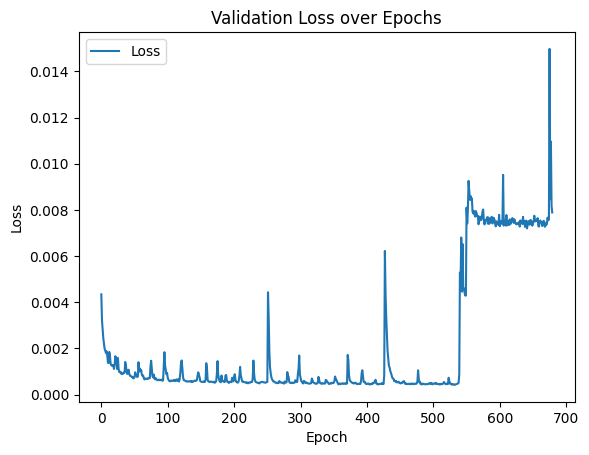

In [23]:
plt.figure()
plt.plot(hist.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

In [30]:
%%time
model.save(f'./saved_models/model_groc_{STATE}_{TEST_YEAR-1}_{model_name}.keras')

df_preds_24 = sum_regions_predictions(model, df_end, enso, TEST_YEAR, columns_to_normalize, True, True)

df_preds_24['adm_1'] = STATE
df_preds_24['adm_0'] = 'BR'
df_preds_24['adm_2'] = pd.NA

df_preds_24.to_csv(f'./predictions/preds_groc_{STATE}_{TEST_YEAR}_{model_name}.csv', index = False)


CPU times: user 21min 19s, sys: 4.19 s, total: 21min 23s
Wall time: 21min 47s


In [31]:
df_24_base = pd.read_csv(f'./predictions/preds_{STATE}_{TEST_YEAR}_{model_name}.csv')
df_24_base.dates = pd.to_datetime(df_24_base.dates)
df_24_base.head()

,dates,lower,preds,upper,adm_1,adm_0,adm_2
0,2023-10-08,0.0,23.917084,2585.251468,MG,BR,NaN
1,2023-10-15,0.0,0.000000,547.943409,MG,BR,NaN
2,2023-10-22,0.0,0.000000,0.000000,MG,BR,NaN
3,2023-10-29,0.0,0.000000,1482.033990,MG,BR,NaN
4,2023-11-05,0.0,0.000000,3043.137634,MG,BR,NaN


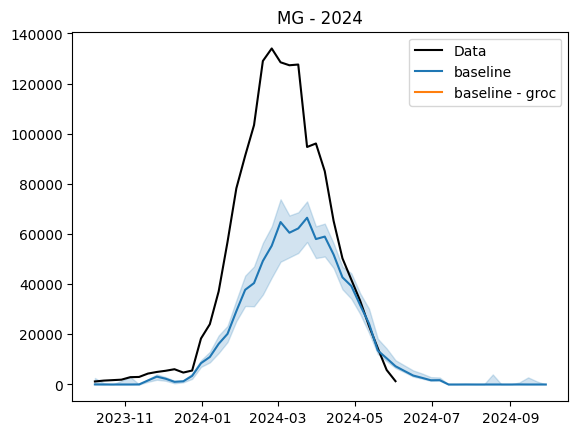

In [32]:
fig,ax = plt.subplots()

ax.plot(data_w.loc[data_w.index.isin(df_24_base.dates)].casos, label = 'Data', color = 'black')
ax.plot(df_24_base.dates, df_24_base.preds, label ='baseline')
ax.fill_between(df_24_base.dates, df_24_base.lower, df_24_base.upper,  color = 'tab:blue', alpha = 0.2)


ax.plot(df_preds_24.dates, df_preds_24.preds, label ='baseline - groc')

ax.fill_between(df_preds_24.dates, df_preds_24.lower, df_preds_24.upper, color = 'tab:orange', alpha = 0.2)

ax.legend()

ax.set_title(f'{STATE} - {TEST_YEAR}')

plt.show()

In [33]:
df_preds_24

,dates,lower,preds,upper,adm_1,adm_0,adm_2
0,2023-10-08,NaN,NaN,NaN,MG,BR,<NA>
1,2023-10-15,NaN,NaN,NaN,MG,BR,<NA>
2,2023-10-22,NaN,NaN,NaN,MG,BR,<NA>
3,2023-10-29,NaN,NaN,NaN,MG,BR,<NA>
4,2023-11-05,NaN,NaN,NaN,MG,BR,<NA>
5,2023-11-12,NaN,NaN,NaN,MG,BR,<NA>
6,2023-11-19,NaN,NaN,NaN,MG,BR,<NA>
7,2023-11-26,NaN,NaN,NaN,MG,BR,<NA>
8,2023-12-03,NaN,NaN,NaN,MG,BR,<NA>
9,2023-12-10,NaN,NaN,NaN,MG,BR,<NA>
